# **Train a CNN to classify images from the CIFAR-10 dataset using PyTorch**

# I. Setup



Install and import necessary libraries and modules.

In [1]:
!pip install optuna

In [2]:
import torch
import torchvision
import optuna
import matplotlib.pyplot as plt
import numpy as np

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

Set device to the first CUDA-enabled GPU if available.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# II. Data Preparation & Processing

`transform` normalizes images to a range of 0 to 1 and scales with mean and standard deviation of 0.5. `train_transform` includes additional transformations like random cropping and horizontal flipping to improve performance by providing a more diverse training dataset. Three datasets (training, validation, test) are created applying these transformations.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [4]:
# Compose a list of image transformations, including tensor conversion and normalization
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Compose a list of training image transformations with additional random crop and horizontal flip
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        torchvision.transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
        torchvision.transforms.RandomHorizontalFlip(),
    ]
)

# Load CIFAR-10 dataset for training using train_transform
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)

# Load CIFAR-10 dataset for validation using basic transform (without data augmentation)
validationset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

# Load CIFAR-10 dataset for testing using basic transform (without data augmentation)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# III. Create a CNN


This model is a simplified ResNet model implemented based on https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/

The model starts with two convolutional layers (`conv1` and `conv2`) followed by batch normalization and ReLU activation function. After `conv2`, there's a max pooling layer that reduces the spatial dimensions of the output.

Next, we have the first residual block (`res1`), which consists of two sub-blocks. Each sub-block has a convolutional layer followed by batch normalization and ReLU activation. The output from this residual block is added back to the input, creating a "shortcut connection" or "residual connection." This helps propagate gradients directly through the shortcut connections, mitigating the vanishing gradient problem.

Following `res1`, there are two more convolutional layers (`conv3` and `conv4`), followed by batch normalization, ReLU activation, and max pooling.

After `conv4`, we have another residual block (`res2`), similar to `res1`. The output from this block is again added back to its input via a shortcut connection.

Finally, the model has a classifier that includes a max pooling layer (to reduce spatial dimensions further), flattening operation (to convert 3D tensor into 1D tensor), and a fully connected layer (for class prediction).

The forward method defines how an input tensor flows through these layers/blocks. It takes an input tensor 'x,' passes it through each layer/block sequentially, applies the residual connections where needed, and finally returns the output from the classifier.
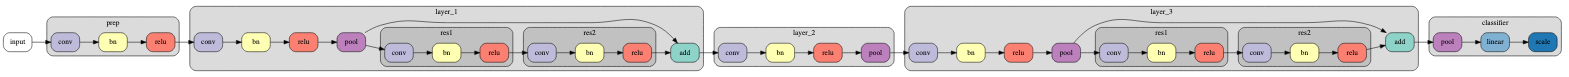

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # First residual block with two convolutional layers
        self.res1 = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
            ),
        )

        # Third convolutional layer with max pooling
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # Fourth convolutional layer with max pooling
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # Second residual block with two convolutional layers
        self.res2 = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
            ),
        )

        # Final classifier with Max Pooling, Flattening, and Linear Layer
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), nn.Flatten(), nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # Apply first residual block and element-wise addition
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply second residual block and element-wise addition
        x = self.res2(x) + x
        x = self.classifier(x)

        return x

Display the network structure tidily.




In [6]:
net = ResNet()
net = net.to(device)

# Batch size is for reference only. Actual batch size is determined later.
summary(net, (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,792
       BatchNorm2d-2           [32, 64, 32, 32]             128
              ReLU-3           [32, 64, 32, 32]               0
            Conv2d-4          [32, 128, 32, 32]          73,856
       BatchNorm2d-5          [32, 128, 32, 32]             256
              ReLU-6          [32, 128, 32, 32]               0
         MaxPool2d-7          [32, 128, 16, 16]               0
            Conv2d-8          [32, 128, 16, 16]         147,584
       BatchNorm2d-9          [32, 128, 16, 16]             256
             ReLU-10          [32, 128, 16, 16]               0
           Conv2d-11          [32, 128, 16, 16]         147,584
      BatchNorm2d-12          [32, 128, 16, 16]             256
             ReLU-13          [32, 128, 16, 16]               0
           Conv2d-14          [32, 256,

# IV. Dataloaders



Split the training set into the `trainloader` and `validloader`. This split is made in accordance to `valid_size`, set as 20% of the total training data. Samplers for the training and validation will be computed and used later during DataLoaders creation. `NUM_WORKERS` for loading data in parallel.

In [7]:
# Set the proportion of the dataset to use for validation
valid_size = 0.2

# Get the number of training examples and create a list of indices
num_train = len(trainset)
indices = list(range(num_train))

# Calculate the index at which to split the dataset into train and validation sets
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
TRAIN_SAMPLER = SubsetRandomSampler(train_idx)
VALID_SAMPLER = SubsetRandomSampler(valid_idx)

# Set the number of workers for data loading
NUM_WORKERS = 2

def data_loaders(trainset, validationset, testset, size):
    # Create a DataLoader for training set using TRAIN_SAMPLER
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=size, sampler=TRAIN_SAMPLER, num_workers=NUM_WORKERS
    )

    # Create a DataLoader for validation set using VALID_SAMPLER
    validloader = torch.utils.data.DataLoader(
        validationset, batch_size=size, sampler=VALID_SAMPLER, num_workers=NUM_WORKERS
    )

    # Create a DataLoader for test set without using any sampler (use all examples)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=size, num_workers=NUM_WORKERS
    )

    # Return DataLoaders as a tuple (trainloader, validloader, testloader)
    return trainloader, validloader, testloader

# V. Training the network


## i. Training function
This function trains the model using CrossEntropyLoss and the Adam optimizer. It takes in a configuration dictionary, training, validation, and test sets, and an optional number of epochs. The function uses a custom `data_loaders` function to load data in batches. For each epoch, it trains the model on the training set and then evaluates it on the validation set to avoid overfitting. If the validation loss decreases, it saves the current model state. The function prints out training statistics after each epoch and returns lists of training losses and accuracies at the end.

In [8]:
def train_cifar(config, trainset, validationset, testset, epochs):
    # Instantiate the model and move it to GPU (if available)
    net = ResNet()
    net.to(device)

    # Define the loss function (Cross-entropy Loss)
    criterion = nn.CrossEntropyLoss()

    # Define the optimizer (Adam with AMSGrad)
    optimizer = optim.Adam(net.parameters(),
                           lr=config["lr"],
                           weight_decay=config["weight_decay"],
                           amsgrad=config["amsgrad"])

    # Create data loaders for train, validation and test sets
    trainloader, validloader, testloader = data_loaders(
        trainset, validationset, testset, config["batch_size"]
    )

    train_loss_list = []
    accuracy_list = []

    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    # Start training loop for given number of epochs
    for epoch in range(epochs):
        train_loss = 0.0
        net.train()

        # Train on batches from train loader
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        correct = 0
        valid_loss = 0.0
        net.eval()

        # Evaluate on batches from validation loader
        for inputs, labels in validloader:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                predicted = torch.max(outputs.data, 1)[1]

                correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(TRAIN_SAMPLER)
        valid_loss = valid_loss / len(VALID_SAMPLER)
        accuracy = correct / len(VALID_SAMPLER)

        train_loss_list.append(train_loss)
        accuracy_list.append(accuracy)

        # Print current epoch's results (Training Loss, Validation Loss, and Accuracy)
        print(
            f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \t"
            f"Validation Loss: {valid_loss:.6f} \t"
            f"Validation Accuracy: {accuracy:.6f}"
        )

        # If validation loss decreased, save model and update valid_loss_min
        if valid_loss <= valid_loss_min:
            print(
                "Validation loss decreased ("
                f"{valid_loss_min:.6f} --> {valid_loss:.6f}).  "
                "Saving model ..."
            )

            torch.save(net.state_dict(), "cnn.pt")
            valid_loss_min = valid_loss
    # End of training loop

    print(f"\n----------- Finished Training -----------")


    return train_loss_list, accuracy_list

## ii. Hyperparameters tuning
This code block defines an Optuna optimization process. The hyperparameters being tuned are learning rate (lr), batch size, and weight decay, with 20 trials conducted. The objective function evaluates the model performance based on its final validation loss.

In [9]:
def objective(trial):
    # Suggest hyperparameters
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0., 1e-4)

    config = {
        "batch_size": batch_size,
        "lr": lr,
        "weight_decay": weight_decay,
        "amsgrad": True
    }

    # Train the model with suggested hyperparameters
    train_loss_list, accuracy_list = train_cifar(config, trainset,
                                                 validationset,
                                                 testset,
                                                 epochs=15)

    # Return the final validation loss
    return train_loss_list[-1]

def optimize_hyperparameters(n_trials):
    # Create an Optuna study with a minimizing objective
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    # Print best_trial information after optimization is complete
    print_best_trial(study)

    return study


def print_best_trial(study):
    # Get best trial from the study
    best_trial = study.best_trial

    print("Best trial:")
    print(f"  Value: {best_trial.value}")
    print(f"  Params: ")

    for key, value in best_trial.params.items():
        print(f"      {key}: {value}")

# Run hyperparameter optimization with 20 trials
study = optimize_hyperparameters(n_trials=20)

[I 2023-11-22 19:50:47,484] A new study created in memory with name: no-name-3ada51f3-0641-4c52-99c0-40155a65a5a3


Epoch: 0 	Training Loss: 1.370594 	Validation Loss: 1.012952 	Validation Accuracy: 0.642300
Validation loss decreased (inf --> 1.012952).  Saving model ...
Epoch: 1 	Training Loss: 1.022947 	Validation Loss: 0.894501 	Validation Accuracy: 0.681900
Validation loss decreased (1.012952 --> 0.894501).  Saving model ...
Epoch: 2 	Training Loss: 0.877651 	Validation Loss: 0.734038 	Validation Accuracy: 0.747300
Validation loss decreased (0.894501 --> 0.734038).  Saving model ...
Epoch: 3 	Training Loss: 0.767017 	Validation Loss: 0.662257 	Validation Accuracy: 0.766100
Validation loss decreased (0.734038 --> 0.662257).  Saving model ...
Epoch: 4 	Training Loss: 0.697791 	Validation Loss: 0.636094 	Validation Accuracy: 0.778100
Validation loss decreased (0.662257 --> 0.636094).  Saving model ...
Epoch: 5 	Training Loss: 0.641195 	Validation Loss: 0.601472 	Validation Accuracy: 0.794100
Validation loss decreased (0.636094 --> 0.601472).  Saving model ...
Epoch: 6 	Training Loss: 0.593939 	Vali

[I 2023-11-22 20:03:15,927] Trial 0 finished with value: 0.38152901157587765 and parameters: {'batch_size': 16, 'lr': 1.8955099951568707e-05, 'weight_decay': 3.691003657877058e-05}. Best is trial 0 with value: 0.38152901157587765.


Epoch: 14 	Training Loss: 0.381529 	Validation Loss: 0.417904 	Validation Accuracy: 0.855500
Validation loss decreased (0.445221 --> 0.417904).  Saving model ...

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.480605 	Validation Loss: 1.115275 	Validation Accuracy: 0.600000
Validation loss decreased (inf --> 1.115275).  Saving model ...
Epoch: 1 	Training Loss: 1.133214 	Validation Loss: 0.941026 	Validation Accuracy: 0.669800
Validation loss decreased (1.115275 --> 0.941026).  Saving model ...
Epoch: 2 	Training Loss: 0.988620 	Validation Loss: 0.843303 	Validation Accuracy: 0.703500
Validation loss decreased (0.941026 --> 0.843303).  Saving model ...
Epoch: 3 	Training Loss: 0.896264 	Validation Loss: 0.769654 	Validation Accuracy: 0.731900
Validation loss decreased (0.843303 --> 0.769654).  Saving model ...
Epoch: 4 	Training Loss: 0.827953 	Validation Loss: 0.723235 	Validation Accuracy: 0.747900
Validation loss decreased (0.769654 --> 0.723235).  Saving model

[I 2023-11-22 20:15:16,273] Trial 1 finished with value: 0.5019407461211085 and parameters: {'batch_size': 16, 'lr': 1.0391772533126187e-05, 'weight_decay': 7.698135320059888e-05}. Best is trial 0 with value: 0.38152901157587765.


Epoch: 14 	Training Loss: 0.501941 	Validation Loss: 0.506962 	Validation Accuracy: 0.824200
Validation loss decreased (0.513056 --> 0.506962).  Saving model ...

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.486255 	Validation Loss: 1.153599 	Validation Accuracy: 0.588600
Validation loss decreased (inf --> 1.153599).  Saving model ...
Epoch: 1 	Training Loss: 1.144258 	Validation Loss: 0.998294 	Validation Accuracy: 0.647300
Validation loss decreased (1.153599 --> 0.998294).  Saving model ...
Epoch: 2 	Training Loss: 0.999660 	Validation Loss: 0.897870 	Validation Accuracy: 0.679500
Validation loss decreased (0.998294 --> 0.897870).  Saving model ...
Epoch: 3 	Training Loss: 0.903761 	Validation Loss: 0.808383 	Validation Accuracy: 0.711000
Validation loss decreased (0.897870 --> 0.808383).  Saving model ...
Epoch: 4 	Training Loss: 0.832002 	Validation Loss: 0.796682 	Validation Accuracy: 0.717000
Validation loss decreased (0.808383 --> 0.796682).  Saving model

[I 2023-11-22 20:24:32,071] Trial 2 finished with value: 0.4970485859155655 and parameters: {'batch_size': 32, 'lr': 1.2346572788546235e-05, 'weight_decay': 9.835114601192971e-05}. Best is trial 0 with value: 0.38152901157587765.


Epoch: 14 	Training Loss: 0.497049 	Validation Loss: 0.540210 	Validation Accuracy: 0.812600

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.269474 	Validation Loss: 0.826284 	Validation Accuracy: 0.711800
Validation loss decreased (inf --> 0.826284).  Saving model ...
Epoch: 1 	Training Loss: 0.791769 	Validation Loss: 0.617606 	Validation Accuracy: 0.786700
Validation loss decreased (0.826284 --> 0.617606).  Saving model ...
Epoch: 2 	Training Loss: 0.625348 	Validation Loss: 0.483795 	Validation Accuracy: 0.835300
Validation loss decreased (0.617606 --> 0.483795).  Saving model ...
Epoch: 3 	Training Loss: 0.535518 	Validation Loss: 0.525069 	Validation Accuracy: 0.825300
Epoch: 4 	Training Loss: 0.469504 	Validation Loss: 0.446408 	Validation Accuracy: 0.850700
Validation loss decreased (0.483795 --> 0.446408).  Saving model ...
Epoch: 5 	Training Loss: 0.414401 	Validation Loss: 0.414831 	Validation Accuracy: 0.861800
Validation loss decreased (0.446408 --> 0

[I 2023-11-22 20:37:16,240] Trial 3 finished with value: 0.20085255991411397 and parameters: {'batch_size': 16, 'lr': 0.0008128258749754285, 'weight_decay': 2.3669161945559983e-05}. Best is trial 3 with value: 0.20085255991411397.


Epoch: 14 	Training Loss: 0.200853 	Validation Loss: 0.316452 	Validation Accuracy: 0.899600

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.156310 	Validation Loss: 0.819599 	Validation Accuracy: 0.709400
Validation loss decreased (inf --> 0.819599).  Saving model ...
Epoch: 1 	Training Loss: 0.728322 	Validation Loss: 0.569875 	Validation Accuracy: 0.807200
Validation loss decreased (0.819599 --> 0.569875).  Saving model ...
Epoch: 2 	Training Loss: 0.575251 	Validation Loss: 0.478079 	Validation Accuracy: 0.835500
Validation loss decreased (0.569875 --> 0.478079).  Saving model ...
Epoch: 3 	Training Loss: 0.487409 	Validation Loss: 0.458058 	Validation Accuracy: 0.846200
Validation loss decreased (0.478079 --> 0.458058).  Saving model ...
Epoch: 4 	Training Loss: 0.427410 	Validation Loss: 0.440244 	Validation Accuracy: 0.853700
Validation loss decreased (0.458058 --> 0.440244).  Saving model ...
Epoch: 5 	Training Loss: 0.376989 	Validation Loss: 0.392155 	Va

[I 2023-11-22 20:46:05,001] Trial 4 finished with value: 0.15738381710797547 and parameters: {'batch_size': 32, 'lr': 0.00030594706127614826, 'weight_decay': 1.5342234068033222e-05}. Best is trial 4 with value: 0.15738381710797547.


Epoch: 14 	Training Loss: 0.157384 	Validation Loss: 0.325679 	Validation Accuracy: 0.892100

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.168010 	Validation Loss: 0.789960 	Validation Accuracy: 0.721900
Validation loss decreased (inf --> 0.789960).  Saving model ...
Epoch: 1 	Training Loss: 0.733359 	Validation Loss: 0.583916 	Validation Accuracy: 0.804200
Validation loss decreased (0.789960 --> 0.583916).  Saving model ...
Epoch: 2 	Training Loss: 0.572551 	Validation Loss: 0.518449 	Validation Accuracy: 0.820600
Validation loss decreased (0.583916 --> 0.518449).  Saving model ...
Epoch: 3 	Training Loss: 0.487553 	Validation Loss: 0.522928 	Validation Accuracy: 0.817300
Epoch: 4 	Training Loss: 0.428289 	Validation Loss: 0.385938 	Validation Accuracy: 0.866700
Validation loss decreased (0.518449 --> 0.385938).  Saving model ...
Epoch: 5 	Training Loss: 0.386138 	Validation Loss: 0.394272 	Validation Accuracy: 0.865800
Epoch: 6 	Training Loss: 0.339757 	Valida

[I 2023-11-22 20:54:51,508] Trial 5 finished with value: 0.1687387450091541 and parameters: {'batch_size': 32, 'lr': 0.00026478304593268207, 'weight_decay': 7.437736282877775e-05}. Best is trial 4 with value: 0.15738381710797547.


Epoch: 14 	Training Loss: 0.168739 	Validation Loss: 0.291162 	Validation Accuracy: 0.902600
Validation loss decreased (0.303881 --> 0.291162).  Saving model ...

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.228503 	Validation Loss: 1.057053 	Validation Accuracy: 0.633400
Validation loss decreased (inf --> 1.057053).  Saving model ...
Epoch: 1 	Training Loss: 0.773629 	Validation Loss: 0.618086 	Validation Accuracy: 0.787000
Validation loss decreased (1.057053 --> 0.618086).  Saving model ...
Epoch: 2 	Training Loss: 0.617944 	Validation Loss: 0.575885 	Validation Accuracy: 0.808400
Validation loss decreased (0.618086 --> 0.575885).  Saving model ...
Epoch: 3 	Training Loss: 0.513454 	Validation Loss: 0.542655 	Validation Accuracy: 0.813500
Validation loss decreased (0.575885 --> 0.542655).  Saving model ...
Epoch: 4 	Training Loss: 0.445618 	Validation Loss: 0.470141 	Validation Accuracy: 0.837600
Validation loss decreased (0.542655 --> 0.470141).  Saving model

[I 2023-11-22 21:03:43,341] Trial 6 finished with value: 0.1607035493902862 and parameters: {'batch_size': 32, 'lr': 0.0009684456151907581, 'weight_decay': 5.8724736201378975e-06}. Best is trial 4 with value: 0.15738381710797547.


Epoch: 14 	Training Loss: 0.160704 	Validation Loss: 0.327092 	Validation Accuracy: 0.898100

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.582663 	Validation Loss: 1.252192 	Validation Accuracy: 0.561800
Validation loss decreased (inf --> 1.252192).  Saving model ...
Epoch: 1 	Training Loss: 1.240217 	Validation Loss: 1.077539 	Validation Accuracy: 0.619800
Validation loss decreased (1.252192 --> 1.077539).  Saving model ...
Epoch: 2 	Training Loss: 1.099106 	Validation Loss: 0.987189 	Validation Accuracy: 0.650500
Validation loss decreased (1.077539 --> 0.987189).  Saving model ...
Epoch: 3 	Training Loss: 1.006832 	Validation Loss: 0.931942 	Validation Accuracy: 0.669500
Validation loss decreased (0.987189 --> 0.931942).  Saving model ...
Epoch: 4 	Training Loss: 0.935806 	Validation Loss: 0.859776 	Validation Accuracy: 0.694700
Validation loss decreased (0.931942 --> 0.859776).  Saving model ...
Epoch: 5 	Training Loss: 0.880501 	Validation Loss: 0.816835 	Va

[I 2023-11-22 21:11:11,757] Trial 7 finished with value: 0.5948207966327668 and parameters: {'batch_size': 64, 'lr': 1.0596368533857326e-05, 'weight_decay': 5.6253286051704e-05}. Best is trial 4 with value: 0.15738381710797547.


Epoch: 14 	Training Loss: 0.594821 	Validation Loss: 0.614461 	Validation Accuracy: 0.782300
Validation loss decreased (0.637153 --> 0.614461).  Saving model ...

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.316691 	Validation Loss: 0.960633 	Validation Accuracy: 0.662600
Validation loss decreased (inf --> 0.960633).  Saving model ...
Epoch: 1 	Training Loss: 0.950124 	Validation Loss: 0.856058 	Validation Accuracy: 0.689600
Validation loss decreased (0.960633 --> 0.856058).  Saving model ...
Epoch: 2 	Training Loss: 0.788644 	Validation Loss: 0.716000 	Validation Accuracy: 0.752100
Validation loss decreased (0.856058 --> 0.716000).  Saving model ...
Epoch: 3 	Training Loss: 0.688539 	Validation Loss: 0.621268 	Validation Accuracy: 0.782000
Validation loss decreased (0.716000 --> 0.621268).  Saving model ...
Epoch: 4 	Training Loss: 0.615303 	Validation Loss: 0.573734 	Validation Accuracy: 0.798300
Validation loss decreased (0.621268 --> 0.573734).  Saving model

[I 2023-11-22 21:20:06,026] Trial 8 finished with value: 0.3065799014419317 and parameters: {'batch_size': 32, 'lr': 3.297668366174174e-05, 'weight_decay': 9.629684757796014e-05}. Best is trial 4 with value: 0.15738381710797547.


Epoch: 14 	Training Loss: 0.306580 	Validation Loss: 0.397035 	Validation Accuracy: 0.864800
Validation loss decreased (0.409281 --> 0.397035).  Saving model ...

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.318332 	Validation Loss: 0.996230 	Validation Accuracy: 0.649400
Validation loss decreased (inf --> 0.996230).  Saving model ...
Epoch: 1 	Training Loss: 0.954218 	Validation Loss: 0.829455 	Validation Accuracy: 0.707900
Validation loss decreased (0.996230 --> 0.829455).  Saving model ...
Epoch: 2 	Training Loss: 0.794434 	Validation Loss: 0.768917 	Validation Accuracy: 0.727400
Validation loss decreased (0.829455 --> 0.768917).  Saving model ...
Epoch: 3 	Training Loss: 0.675753 	Validation Loss: 0.647854 	Validation Accuracy: 0.770600
Validation loss decreased (0.768917 --> 0.647854).  Saving model ...
Epoch: 4 	Training Loss: 0.603166 	Validation Loss: 0.551121 	Validation Accuracy: 0.808300
Validation loss decreased (0.647854 --> 0.551121).  Saving model

[I 2023-11-22 21:27:35,537] Trial 9 finished with value: 0.2730850472807884 and parameters: {'batch_size': 64, 'lr': 5.323424727257437e-05, 'weight_decay': 3.28410347001024e-05}. Best is trial 4 with value: 0.15738381710797547.


Epoch: 14 	Training Loss: 0.273085 	Validation Loss: 0.423608 	Validation Accuracy: 0.858800

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.153695 	Validation Loss: 0.772102 	Validation Accuracy: 0.726700
Validation loss decreased (inf --> 0.772102).  Saving model ...
Epoch: 1 	Training Loss: 0.742902 	Validation Loss: 0.624100 	Validation Accuracy: 0.779400
Validation loss decreased (0.772102 --> 0.624100).  Saving model ...
Epoch: 2 	Training Loss: 0.598851 	Validation Loss: 0.559415 	Validation Accuracy: 0.809000
Validation loss decreased (0.624100 --> 0.559415).  Saving model ...
Epoch: 3 	Training Loss: 0.509912 	Validation Loss: 0.463508 	Validation Accuracy: 0.840300
Validation loss decreased (0.559415 --> 0.463508).  Saving model ...
Epoch: 4 	Training Loss: 0.446045 	Validation Loss: 0.448681 	Validation Accuracy: 0.847700
Validation loss decreased (0.463508 --> 0.448681).  Saving model ...
Epoch: 5 	Training Loss: 0.394430 	Validation Loss: 0.437945 	Va

[I 2023-11-22 21:36:26,003] Trial 10 finished with value: 0.17295410988628865 and parameters: {'batch_size': 32, 'lr': 0.0001485572420894254, 'weight_decay': 1.1570390831219157e-06}. Best is trial 4 with value: 0.15738381710797547.


Epoch: 14 	Training Loss: 0.172954 	Validation Loss: 0.322598 	Validation Accuracy: 0.892400

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.291507 	Validation Loss: 0.854556 	Validation Accuracy: 0.698200
Validation loss decreased (inf --> 0.854556).  Saving model ...
Epoch: 1 	Training Loss: 0.796472 	Validation Loss: 0.706685 	Validation Accuracy: 0.762700
Validation loss decreased (0.854556 --> 0.706685).  Saving model ...
Epoch: 2 	Training Loss: 0.628325 	Validation Loss: 0.544641 	Validation Accuracy: 0.810000
Validation loss decreased (0.706685 --> 0.544641).  Saving model ...
Epoch: 3 	Training Loss: 0.535479 	Validation Loss: 0.453657 	Validation Accuracy: 0.848600
Validation loss decreased (0.544641 --> 0.453657).  Saving model ...
Epoch: 4 	Training Loss: 0.453580 	Validation Loss: 0.501566 	Validation Accuracy: 0.830700
Epoch: 5 	Training Loss: 0.400607 	Validation Loss: 0.431453 	Validation Accuracy: 0.850100
Validation loss decreased (0.453657 --> 0

[I 2023-11-22 21:45:25,511] Trial 11 finished with value: 0.1537576436020434 and parameters: {'batch_size': 32, 'lr': 0.0009271466912472205, 'weight_decay': 3.348677382119085e-06}. Best is trial 11 with value: 0.1537576436020434.


Epoch: 14 	Training Loss: 0.153758 	Validation Loss: 0.313236 	Validation Accuracy: 0.897900

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.167562 	Validation Loss: 0.857452 	Validation Accuracy: 0.702200
Validation loss decreased (inf --> 0.857452).  Saving model ...
Epoch: 1 	Training Loss: 0.724658 	Validation Loss: 0.664139 	Validation Accuracy: 0.765200
Validation loss decreased (0.857452 --> 0.664139).  Saving model ...
Epoch: 2 	Training Loss: 0.579260 	Validation Loss: 0.486179 	Validation Accuracy: 0.832300
Validation loss decreased (0.664139 --> 0.486179).  Saving model ...
Epoch: 3 	Training Loss: 0.492827 	Validation Loss: 0.453167 	Validation Accuracy: 0.839000
Validation loss decreased (0.486179 --> 0.453167).  Saving model ...
Epoch: 4 	Training Loss: 0.426783 	Validation Loss: 0.436581 	Validation Accuracy: 0.846300
Validation loss decreased (0.453167 --> 0.436581).  Saving model ...
Epoch: 5 	Training Loss: 0.376877 	Validation Loss: 0.415252 	Va

[I 2023-11-22 21:54:23,652] Trial 12 finished with value: 0.1569633334554732 and parameters: {'batch_size': 32, 'lr': 0.0004202602996997231, 'weight_decay': 1.593681784806845e-05}. Best is trial 11 with value: 0.1537576436020434.


Epoch: 14 	Training Loss: 0.156963 	Validation Loss: 0.309136 	Validation Accuracy: 0.898200

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.182061 	Validation Loss: 0.850212 	Validation Accuracy: 0.705700
Validation loss decreased (inf --> 0.850212).  Saving model ...
Epoch: 1 	Training Loss: 0.738912 	Validation Loss: 0.560044 	Validation Accuracy: 0.804300
Validation loss decreased (0.850212 --> 0.560044).  Saving model ...
Epoch: 2 	Training Loss: 0.581980 	Validation Loss: 0.536346 	Validation Accuracy: 0.815200
Validation loss decreased (0.560044 --> 0.536346).  Saving model ...
Epoch: 3 	Training Loss: 0.492963 	Validation Loss: 0.436617 	Validation Accuracy: 0.848000
Validation loss decreased (0.536346 --> 0.436617).  Saving model ...
Epoch: 4 	Training Loss: 0.426079 	Validation Loss: 0.443546 	Validation Accuracy: 0.848100
Epoch: 5 	Training Loss: 0.377979 	Validation Loss: 0.410917 	Validation Accuracy: 0.857600
Validation loss decreased (0.436617 --> 0

[I 2023-11-22 22:03:19,219] Trial 13 finished with value: 0.14781985794454813 and parameters: {'batch_size': 32, 'lr': 0.0004931081298378134, 'weight_decay': 6.465137759110095e-07}. Best is trial 13 with value: 0.14781985794454813.


Epoch: 14 	Training Loss: 0.147820 	Validation Loss: 0.287075 	Validation Accuracy: 0.905800

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.181259 	Validation Loss: 0.829472 	Validation Accuracy: 0.702800
Validation loss decreased (inf --> 0.829472).  Saving model ...
Epoch: 1 	Training Loss: 0.730932 	Validation Loss: 0.657408 	Validation Accuracy: 0.770900
Validation loss decreased (0.829472 --> 0.657408).  Saving model ...
Epoch: 2 	Training Loss: 0.584387 	Validation Loss: 0.502667 	Validation Accuracy: 0.828100
Validation loss decreased (0.657408 --> 0.502667).  Saving model ...
Epoch: 3 	Training Loss: 0.493785 	Validation Loss: 0.550145 	Validation Accuracy: 0.815500
Epoch: 4 	Training Loss: 0.424484 	Validation Loss: 0.429577 	Validation Accuracy: 0.851800
Validation loss decreased (0.502667 --> 0.429577).  Saving model ...
Epoch: 5 	Training Loss: 0.377938 	Validation Loss: 0.457635 	Validation Accuracy: 0.849300
Epoch: 6 	Training Loss: 0.333562 	Valida

[I 2023-11-22 22:10:49,356] Trial 14 finished with value: 0.14316179801821707 and parameters: {'batch_size': 64, 'lr': 0.0005649188932645299, 'weight_decay': 2.8403842667842503e-06}. Best is trial 14 with value: 0.14316179801821707.


Epoch: 14 	Training Loss: 0.143162 	Validation Loss: 0.319492 	Validation Accuracy: 0.898700

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.239696 	Validation Loss: 0.902101 	Validation Accuracy: 0.681400
Validation loss decreased (inf --> 0.902101).  Saving model ...
Epoch: 1 	Training Loss: 0.816687 	Validation Loss: 0.680783 	Validation Accuracy: 0.761600
Validation loss decreased (0.902101 --> 0.680783).  Saving model ...
Epoch: 2 	Training Loss: 0.653314 	Validation Loss: 0.576766 	Validation Accuracy: 0.802700
Validation loss decreased (0.680783 --> 0.576766).  Saving model ...
Epoch: 3 	Training Loss: 0.554311 	Validation Loss: 0.519427 	Validation Accuracy: 0.822200
Validation loss decreased (0.576766 --> 0.519427).  Saving model ...
Epoch: 4 	Training Loss: 0.482482 	Validation Loss: 0.576428 	Validation Accuracy: 0.800600
Epoch: 5 	Training Loss: 0.433464 	Validation Loss: 0.464400 	Validation Accuracy: 0.843000
Validation loss decreased (0.519427 --> 0

[I 2023-11-22 22:18:23,163] Trial 15 finished with value: 0.18546089613437652 and parameters: {'batch_size': 64, 'lr': 0.00013227620840102776, 'weight_decay': 1.61612100127786e-05}. Best is trial 14 with value: 0.14316179801821707.


Epoch: 14 	Training Loss: 0.185461 	Validation Loss: 0.356737 	Validation Accuracy: 0.880800

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.178665 	Validation Loss: 1.004276 	Validation Accuracy: 0.657900
Validation loss decreased (inf --> 1.004276).  Saving model ...
Epoch: 1 	Training Loss: 0.734888 	Validation Loss: 0.663654 	Validation Accuracy: 0.770700
Validation loss decreased (1.004276 --> 0.663654).  Saving model ...
Epoch: 2 	Training Loss: 0.579115 	Validation Loss: 0.572322 	Validation Accuracy: 0.799900
Validation loss decreased (0.663654 --> 0.572322).  Saving model ...
Epoch: 3 	Training Loss: 0.494995 	Validation Loss: 0.469858 	Validation Accuracy: 0.838400
Validation loss decreased (0.572322 --> 0.469858).  Saving model ...
Epoch: 4 	Training Loss: 0.424656 	Validation Loss: 0.452133 	Validation Accuracy: 0.843900
Validation loss decreased (0.469858 --> 0.452133).  Saving model ...
Epoch: 5 	Training Loss: 0.373302 	Validation Loss: 0.421669 	Va

[I 2023-11-22 22:25:55,784] Trial 16 finished with value: 0.1541076188325882 and parameters: {'batch_size': 64, 'lr': 0.0005097552356371062, 'weight_decay': 3.121519846288315e-05}. Best is trial 14 with value: 0.14316179801821707.


Epoch: 14 	Training Loss: 0.154108 	Validation Loss: 0.366496 	Validation Accuracy: 0.884300

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.198283 	Validation Loss: 0.898525 	Validation Accuracy: 0.677400
Validation loss decreased (inf --> 0.898525).  Saving model ...
Epoch: 1 	Training Loss: 0.754832 	Validation Loss: 0.718038 	Validation Accuracy: 0.751400
Validation loss decreased (0.898525 --> 0.718038).  Saving model ...
Epoch: 2 	Training Loss: 0.605320 	Validation Loss: 0.597212 	Validation Accuracy: 0.793100
Validation loss decreased (0.718038 --> 0.597212).  Saving model ...
Epoch: 3 	Training Loss: 0.513637 	Validation Loss: 0.579313 	Validation Accuracy: 0.801500
Validation loss decreased (0.597212 --> 0.579313).  Saving model ...
Epoch: 4 	Training Loss: 0.448383 	Validation Loss: 0.489962 	Validation Accuracy: 0.836300
Validation loss decreased (0.579313 --> 0.489962).  Saving model ...
Epoch: 5 	Training Loss: 0.391807 	Validation Loss: 0.455548 	Va

[I 2023-11-22 22:33:32,301] Trial 17 finished with value: 0.16913461517095565 and parameters: {'batch_size': 64, 'lr': 0.0002146070168770092, 'weight_decay': 4.3139794263152415e-05}. Best is trial 14 with value: 0.14316179801821707.


Epoch: 14 	Training Loss: 0.169135 	Validation Loss: 0.322931 	Validation Accuracy: 0.893200

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.158270 	Validation Loss: 0.752077 	Validation Accuracy: 0.740700
Validation loss decreased (inf --> 0.752077).  Saving model ...
Epoch: 1 	Training Loss: 0.718984 	Validation Loss: 0.704495 	Validation Accuracy: 0.755200
Validation loss decreased (0.752077 --> 0.704495).  Saving model ...
Epoch: 2 	Training Loss: 0.582934 	Validation Loss: 0.535756 	Validation Accuracy: 0.815900
Validation loss decreased (0.704495 --> 0.535756).  Saving model ...
Epoch: 3 	Training Loss: 0.488252 	Validation Loss: 0.501329 	Validation Accuracy: 0.828700
Validation loss decreased (0.535756 --> 0.501329).  Saving model ...
Epoch: 4 	Training Loss: 0.421102 	Validation Loss: 0.463681 	Validation Accuracy: 0.843300
Validation loss decreased (0.501329 --> 0.463681).  Saving model ...
Epoch: 5 	Training Loss: 0.374723 	Validation Loss: 0.443123 	Va

[I 2023-11-22 22:41:06,025] Trial 18 finished with value: 0.14768403348326684 and parameters: {'batch_size': 64, 'lr': 0.0004886166953866086, 'weight_decay': 1.0996838610984747e-05}. Best is trial 14 with value: 0.14316179801821707.


Epoch: 14 	Training Loss: 0.147684 	Validation Loss: 0.298017 	Validation Accuracy: 0.904500
Validation loss decreased (0.303061 --> 0.298017).  Saving model ...

----------- Finished Training -----------
Epoch: 0 	Training Loss: 1.244732 	Validation Loss: 0.934946 	Validation Accuracy: 0.665400
Validation loss decreased (inf --> 0.934946).  Saving model ...
Epoch: 1 	Training Loss: 0.856910 	Validation Loss: 0.848361 	Validation Accuracy: 0.705400
Validation loss decreased (0.934946 --> 0.848361).  Saving model ...
Epoch: 2 	Training Loss: 0.692463 	Validation Loss: 0.603181 	Validation Accuracy: 0.789200
Validation loss decreased (0.848361 --> 0.603181).  Saving model ...
Epoch: 3 	Training Loss: 0.586439 	Validation Loss: 0.572930 	Validation Accuracy: 0.802300
Validation loss decreased (0.603181 --> 0.572930).  Saving model ...
Epoch: 4 	Training Loss: 0.516561 	Validation Loss: 0.519914 	Validation Accuracy: 0.820800
Validation loss decreased (0.572930 --> 0.519914).  Saving model

[I 2023-11-22 22:48:36,435] Trial 19 finished with value: 0.20879869564771653 and parameters: {'batch_size': 64, 'lr': 9.695088693278583e-05, 'weight_decay': 2.4085901981053108e-05}. Best is trial 14 with value: 0.14316179801821707.


Epoch: 14 	Training Loss: 0.208799 	Validation Loss: 0.393525 	Validation Accuracy: 0.867300

----------- Finished Training -----------
Best trial:
  Value: 0.14316179801821707
  Params: 
      batch_size: 64
      lr: 0.0005649188932645299
      weight_decay: 2.8403842667842503e-06


Train the model again with the best configuration found during optimization in 40 epochs

In [11]:
best_config = study.best_trial.params
best_config["amsgrad"] = True

EPOCHS = 40
train_loss_list, accuracy_list = train_cifar(best_config, trainset, validationset, testset, EPOCHS)

Epoch: 0 	Training Loss: 1.162202 	Validation Loss: 0.823535 	Validation Accuracy: 0.716800
Validation loss decreased (inf --> 0.823535).  Saving model ...
Epoch: 1 	Training Loss: 0.724199 	Validation Loss: 0.679056 	Validation Accuracy: 0.767200
Validation loss decreased (0.823535 --> 0.679056).  Saving model ...
Epoch: 2 	Training Loss: 0.581179 	Validation Loss: 0.537925 	Validation Accuracy: 0.815200
Validation loss decreased (0.679056 --> 0.537925).  Saving model ...
Epoch: 3 	Training Loss: 0.485160 	Validation Loss: 0.526997 	Validation Accuracy: 0.819500
Validation loss decreased (0.537925 --> 0.526997).  Saving model ...
Epoch: 4 	Training Loss: 0.422840 	Validation Loss: 0.477856 	Validation Accuracy: 0.831800
Validation loss decreased (0.526997 --> 0.477856).  Saving model ...
Epoch: 5 	Training Loss: 0.372345 	Validation Loss: 0.410290 	Validation Accuracy: 0.859700
Validation loss decreased (0.477856 --> 0.410290).  Saving model ...
Epoch: 6 	Training Loss: 0.328125 	Vali

# VI. Evaluation

Display the training progress

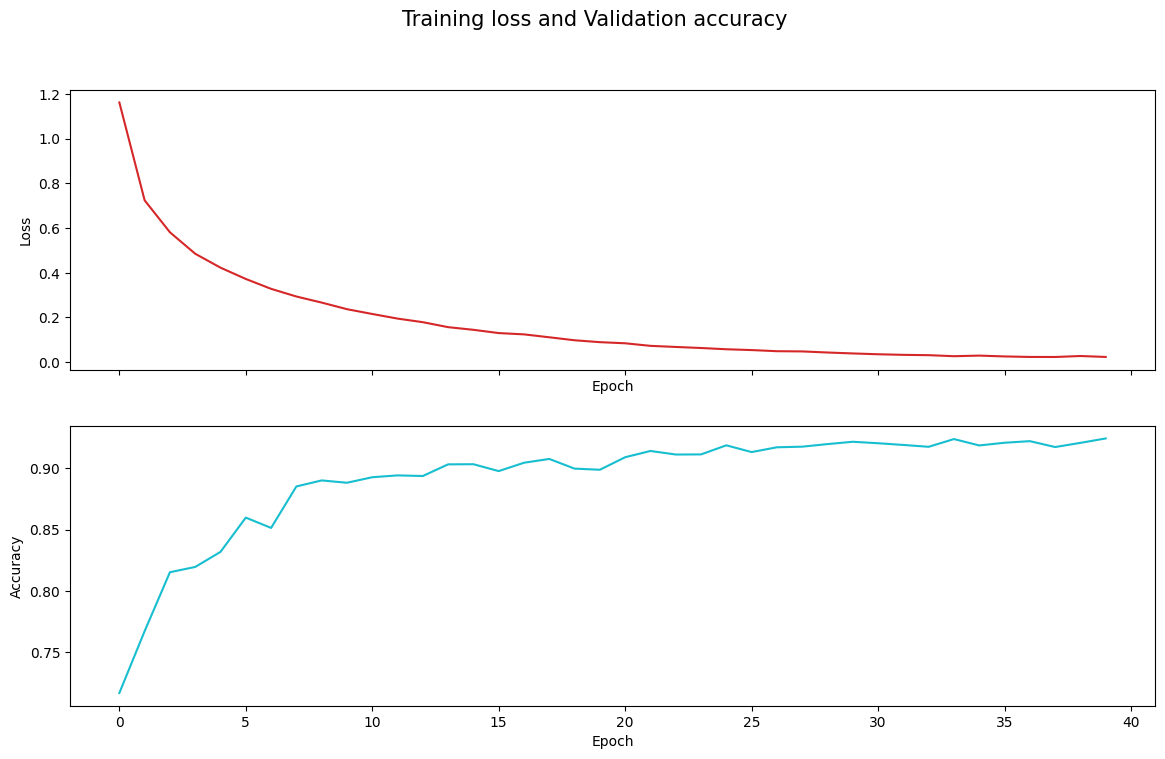

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 8), sharex=True)
fig.suptitle("Training loss and Validation accuracy", size=15)

ax1.plot([*range(EPOCHS)], train_loss_list, "tab:red", label="train loss")
ax1.set(xlabel="Epoch", ylabel="Loss")

plt.plot([*range(EPOCHS)], accuracy_list, "tab:cyan", label="accuracy")
ax2.set(xlabel="Epoch", ylabel="Accuracy")

fig.show()

- `test_accuracy(net, testloader)`: Calculates the overall accuracy of the model
- `test_accuracy_per_class(net, testloader)`: Calculates class-wise accuracy

`net.eval()` is called before testing starts to put the network into evaluation mode. Also, `torch.no_grad()` is used as a context manager to disable gradient calculations during inference which can save memory.


In [13]:
def test_accuracy(net, testloader):
    correct = 0

    # Disable gradient calculations during testing to save memory and improve performance
    with torch.no_grad():
        net.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # Get network predictions for test images
            outputs = net(images)

            # Find class label with highest probability for each image
            predicted = torch.max(outputs.data, 1)[1]

            # Compare predictions to true label
            correct += (predicted == labels).sum().item()

    return correct / len(testloader.dataset)

def test_accuracy_per_class(net, testloader):
    correct_pred = {classname: 0 for classname in trainset.classes}
    total_pred = {classname: 0 for classname in trainset.classes}

    with torch.no_grad():
        net.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # Get network predictions for test images
            outputs = net(images)

            # Find class label with highest probability for each image
            predicted = torch.max(outputs.data, 1)[1]

            # Compare predictions to true label
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[trainset.classes[label]] += 1
                total_pred[trainset.classes[label]] += 1

    # Calculate accuracy for each class
    accuracy_per_class = {classname: 0 for classname in trainset.classes}
    for classname, correct_count in correct_pred.items():
        accuracy = (100 * float(correct_count)) / total_pred[classname]
        accuracy_per_class[classname] = accuracy

    return accuracy_per_class

Test the accuracy of the best model (cnn.pt)

In [14]:
_, _, testloader = data_loaders(trainset, validationset, testset, best_config["batch_size"])

trained_net = ResNet()
trained_net.to(device)

# Load the saved best model from above
trained_net.load_state_dict(torch.load("cnn.pt"))

overall_accuracy = test_accuracy(trained_net, testloader)

print("Overall accuracy  " f"{(overall_accuracy * 100):.2f} %\n")

accuracy_per_class = test_accuracy_per_class(trained_net, testloader)

for classname, accuracy in accuracy_per_class.items():
    print(f"{classname:12s} {accuracy:.2f} %")

Overall accuracy  90.99 %

airplane     92.90 %
automobile   96.60 %
bird         88.80 %
cat          74.40 %
deer         93.40 %
dog          88.10 %
frog         94.20 %
horse        94.10 %
ship         94.70 %
truck        92.70 %
